# <b>MODEL CREATION AND TESTING</b>

This notebook will be focus on the regression model, however it will also have a series of visualization plots and other tools that will be use for the EDA and to try to answer the following questions:

* In which sector should you buy?
* What is the price per square foot in each one of those sectors?
* How many bedrooms and bathrooms should you looking at?
* Does age play a role on the price of the homes?

To make it simpler, instead of dealing with the 70 different postcodes the area has been divided into 4 sectors/quadrants. This is probably not the ideal case scenario if you are looking for a specific zipcode but as a first pass it should work. What can be done also is that when the sector has been define, it can be used to shortlist the postcodes within it with a simple code. Then you can get creative and tackle the homes within that sector(s) with any of the predictable variables that the model will suggest at the end.

Again, I will start by loading the necessary libraries:

## Libraries

Below is the list of the libraries that will be use for the entire notebook:

In [1]:
import  pandas as pd
import  numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
# These two lines are to ingnore warnings that normally are within pink boxes

import warnings
warnings.filterwarnings('ignore')

## Data Loading and viewing

In [3]:
df1 = pd.read_csv('df_cleaned_1.csv', index_col=0)
pd.set_option('display.max_columns', 500) # Allows to display up to 500 columns
df1.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,month_sale,year_sale,renovation,sector_1,sector_2,sector_3,sector_4,Grade_A,Grade_B,Grade_C,Grade_D,home_age
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0,47.5112,-122.257,1340,5650,10,2014,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,65
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,47.7210,-122.319,1690,7639,12,2014,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,69
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,0.0,47.7379,-122.233,2720,8062,2,2015,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,87
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,47.5208,-122.393,1360,5000,12,2014,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,47.6168,-122.045,1800,7503,2,2015,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,33


In [4]:
df1.shape

(20240, 30)

The .shape indicates that we have 24 columns. It is more than what thee database initially had because some of them have been engineered

In [5]:
df1.info() # Quick check on data types and number of rows for each column 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20240 entries, 0 to 21596
Data columns (total 30 columns):
id               20240 non-null int64
price            20240 non-null float64
bedrooms         20240 non-null int64
bathrooms        20240 non-null float64
sqft_living      20240 non-null int64
sqft_lot         20240 non-null int64
floors           20240 non-null float64
waterfront       20240 non-null float64
condition        20240 non-null int64
grade            20240 non-null int64
sqft_above       20240 non-null int64
sqft_basement    20240 non-null float64
yr_built         20240 non-null int64
yr_renovated     20240 non-null float64
lat              20240 non-null float64
long             20240 non-null float64
sqft_living15    20240 non-null int64
sqft_lot15       20240 non-null int64
month_sale       20240 non-null int64
year_sale        20240 non-null int64
renovation       20240 non-null int64
sector_1         20240 non-null float64
sector_2         20240 non-null float

In [6]:
df1.describe() # Quick check on the statistics of each one of the colums

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,month_sale,year_sale,renovation,sector_1,sector_2,sector_3,sector_4,Grade_A,Grade_B,Grade_C,Grade_D,home_age
count,2.024000e+04,2.024000e+04,20240.000000,20240.000000,20240.000000,2.024000e+04,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000,20240.000000
mean,4.604291e+09,4.772575e+05,3.328804,2.053286,1975.765662,1.462167e+04,1.477050,0.003458,3.407460,7.533300,1709.116008,261.023468,1970.903755,61.030336,47.556897,-122.213043,1922.639575,12446.676532,6.567737,2014.324901,0.030583,0.270751,0.403409,0.242045,0.078360,0.012945,0.829200,0.157609,0.000247,49.096245
std,2.877514e+09,2.062737e+05,0.882515,0.709023,772.005650,4.017194e+04,0.537036,0.058709,0.646253,1.033066,726.312923,405.508417,29.163761,343.626299,0.141151,0.142396,613.878116,26556.400066,3.120068,0.468349,0.172189,0.444359,0.490594,0.428332,0.268743,0.113039,0.376344,0.364383,0.015716,29.163761
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000,1.000000,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,2.132076e+09,3.160000e+05,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,0.000000,3.000000,7.000000,1180.000000,0.000000,1952.000000,0.000000,47.460100,-122.330000,1470.000000,5040.000000,4.000000,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,24.000000
50%,3.905081e+09,4.390000e+05,3.000000,2.000000,1860.000000,7.500000e+03,1.000000,0.000000,3.000000,7.000000,1520.000000,0.000000,1975.000000,0.000000,47.567000,-122.231000,1800.000000,7537.000000,6.000000,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,45.000000
75%,7.338200e+09,6.000000e+05,4.000000,2.500000,2430.000000,1.031625e+04,2.000000,0.000000,4.000000,8.000000,2100.000000,500.000000,1996.000000,0.000000,47.679900,-122.122000,2280.000000,9880.750000,9.000000,2015.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,68.000000
max,9.900000e+09,1.100000e+06,11.000000,7.500000,7480.000000,1.651359e+06,3.500000,1.000000,5.000000,12.000000,5710.000000,2720.000000,2015.000000,2015.000000,47.777600,-121.315000,4950.000000,871200.000000,12.000000,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,120.000000


## Dealing with categoricals

From the data cleaning and visualization the following categoricals have been identified:

* waterfront (this one was created as a 1 for homes with waterfront view, and a 0 with no waterfront view)
* condition
* renovation: This is an engineered column done with a simple 1 for houses being renovated, and 0 for not renovated
* grades: Because there were 11 grades, it was decided to binned them into 4 general grades (details in the Data Cleaning notebook)
* zipcode: as mentioned above, 4 differentt sectors/quadrants were made based on lat/long, which will replace the zipcodes, therefore zipcode was dropped
* months: month_sale was an engineered column, however due to the high correlation with year_sale it was decided to drop it and maybe use it for other more detail individual analysis later on.
   

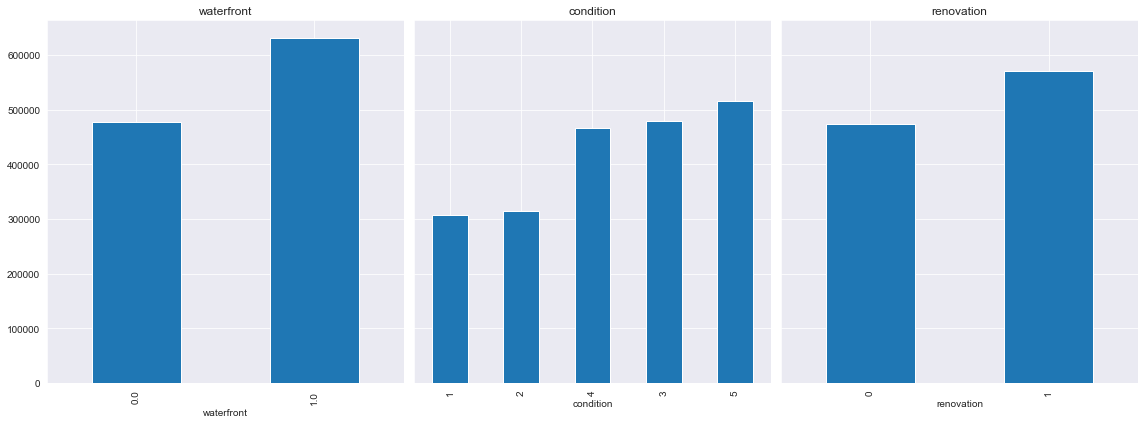

In [7]:
# These plots are for the 3 categorical variables that I will be working with: 

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6), sharey=True)

categoricals = ['waterfront', 'condition', 'renovation']

for col, ax in zip(categoricals, axes.flatten()):
    (df1.groupby(col).mean()['price'].sort_values().plot.bar(ax=ax))
    
# The previous for loop is doing the following per selected plot:
# .groupby(col) = groups the values together by column of interest
# .mean()['price'] = takes the mean of the price for each group
# .bar(ax=ax) = creates a bar graph on the ax 
# set_title(col) = takes the column title ans uses it as the graph title

    ax.set_title(col)
fig.tight_layout()


Before I create the dummy variables I will also look at each column in a scatter plot plotted against the price. Remember that I put a threshold for the house prices at 1.1 million US$, hence the plots will be cropped on the top.

Now I know these are a lot of plots, but this will be very useful to better understand the data distribution of each variable, so it is also a part of the EDA.

In [8]:
# I have commented this plots to make this Notebook slightly shorter. Please un-comment 
# to better understand the "OBSERVATIONS" below.

#for col in df1.columns:
#    plt.scatter(df1[col], df1.price, label=col)
#    plt.legend()
#    plt.xlabel(col)
#    plt.ylabel('price')
#    plt.title(col)
#    plt.show()

In [8]:
#for col in df1.columns:
#    sns.lmplot(x= col, y = 'price', data = df1, line_kws={'color': 'red'})
#    plt.show()

# These plot were commented to avoid making the notebook longer than what it already is.
# Uncomment it to better understand the Observations described below

OBSERVATIONS from both of the previous plots:

* bedroom vs price: It is clear that in average, the house price increases with increasing number of bedrooms until a number of 6 is reached. After this, the average price starts to decrease. This is interesting to take into account, as for large families it might be interesting to look at houses with more than 6 bedrooms. This is happening when looking at all the data together. I'm not sure the same will happen when I split the data into sectors, so this will be interesting to see. 

* Bathrooms vs price: The more bathrooms you have, the more expensive the house seems to get. There must be a magic number when this trend stops and even maybe it switchs to a lost in price (?)

* Square footage vs price: The price of the square foot increases in average with the increase of the house size, however, as house increase their size the error increases given space for large variations which I believe will be related to other variables such as the zipcode and waterfront location. 

* square foot of the lot vs price: This plot has too many outliers so the analyzes will be biased and erroneous. For more inside to this I will generate on a separate notebook a separate plot with the data filtered from outliers and using the rule of the 3 standard deviations

* floors vs price: This is a similar case as with the bedrooms. It seems as the price of the properties increases up to a certain point and then it start to decrease. 

* waterfront and condition are both categoricals so hard to make a comment with these type of plots. However, as I have plotted the house prices on a map, I know that the most expensive homes are on the waterfront, and that in average, the better the condition of the house the more expensive it will be, but again there comes a point where the conditions get better but the price decreases or stays the same. More detail on this when I look at the variables separately. 

* The sqft_living is highly correlated to the sqft_living_15 and the same goes for sqft_lot and sqft_lot15. It should have an impact on the price as the nicer the neighborhood the more expensive houses are. This is my simple thinking so I guess I will see if this is true with the model results.  

* The sqft_living = sqft_above + sqft_basement


In [9]:
# I will now define the three categoricals that I will be working with,
# proceed to generate dummies for each one, drop the columns from the df1
# and concatenate the new dataframes with df1

categoricals = ['waterfront', 'condition', 'renovation']

In [10]:
waterfront_dummies = pd.get_dummies(df1['waterfront'], prefix='waterfront', drop_first=True)
condition_dummies = pd.get_dummies(df1['condition'], prefix='condition', drop_first=True)
renovation_dummies = pd.get_dummies(df1['renovation'], prefix='renovation', drop_first=True)

In [11]:
df1 = df1.drop(['waterfront', 'condition', 'renovation'], axis=1)

In [12]:
df1 = pd.concat([df1, waterfront_dummies, condition_dummies, renovation_dummies], axis=1)

In [13]:
df1.head(3)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,month_sale,year_sale,sector_1,sector_2,sector_3,sector_4,Grade_A,Grade_B,Grade_C,Grade_D,home_age,waterfront_1.0,condition_2,condition_3,condition_4,condition_5,renovation_1
0,7129300520,221900.0,3,1.00,1180,5650,1.0,7,1180,0.0,1955,0.0,47.5112,-122.257,1340,5650,10,2014,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,65,0,0,1,0,0,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,7,2170,400.0,1951,1991.0,47.7210,-122.319,1690,7639,12,2014,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,69,0,0,1,0,0,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,6,770,0.0,1933,0.0,47.7379,-122.233,2720,8062,2,2015,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,87,0,0,1,0,0,0


In [14]:
# This correlation of all the columns will start to give me an idea of possible 
# colinearity and multicollinearity. Some of the pairs with very high correlations 
# (75% and higher) will require to chose one to be dropped

df1.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,month_sale,year_sale,sector_1,sector_2,sector_3,sector_4,Grade_A,Grade_B,Grade_C,Grade_D,home_age,waterfront_1.0,condition_2,condition_3,condition_4,condition_5,renovation_1
id,1.000000,0.008363,0.010588,0.022030,0.005691,-0.133340,0.028666,0.029570,0.008814,-0.005046,0.024346,-0.013957,0.001903,0.019442,0.010197,-0.143183,-0.010350,0.007544,0.004754,0.025754,-0.047286,0.019330,-0.025267,0.002495,0.005355,-0.002169,-0.024346,-0.008531,-0.012615,0.032979,-0.026487,-0.011323,-0.013961
price,0.008363,1.000000,0.300063,0.452300,0.618677,0.093582,0.270434,0.628243,0.527416,0.228628,0.057338,0.081362,0.432423,0.071376,0.560416,0.082204,-0.010479,-0.001962,0.083247,0.392985,-0.399826,-0.216224,-0.128094,-0.463061,0.516356,0.038084,-0.057338,0.044054,-0.070356,0.016555,-0.034114,0.054649,0.080979
bedrooms,0.010588,0.300063,1.000000,0.505143,0.602248,0.025661,0.159999,0.329446,0.478785,0.280208,0.166451,0.001058,-0.034435,0.146664,0.384407,0.022853,-0.001405,-0.008274,-0.189478,0.137095,0.050871,-0.015100,-0.133306,-0.166517,0.212668,0.015518,-0.166451,-0.018135,-0.049063,0.006039,-0.003040,0.014980,0.000803
bathrooms,0.022030,0.452300,0.505143,1.000000,0.716492,0.064710,0.501773,0.613218,0.637793,0.215440,0.544707,0.022996,-0.011003,0.248697,0.528287,0.064760,0.010167,-0.031195,-0.184389,0.183939,0.023908,-0.062690,-0.155485,-0.347152,0.405016,0.040943,-0.544707,-0.009472,-0.074971,0.201532,-0.171381,-0.046274,0.022569
sqft_living,0.005691,0.618677,0.602248,0.716492,1.000000,0.159103,0.338984,0.703938,0.853238,0.366731,0.353787,0.018362,0.008320,0.286985,0.737433,0.173210,0.016248,-0.034371,-0.247977,0.248099,0.004216,-0.043059,-0.152054,-0.504448,0.565531,0.061336,-0.353787,-0.001967,-0.066539,0.114181,-0.083717,-0.039016,0.018162
sqft_lot,-0.133340,0.093582,0.025661,0.064710,0.159103,1.000000,-0.017602,0.093478,0.162367,0.011888,0.041871,0.007431,-0.094877,0.222392,0.142776,0.708722,0.002863,-0.000291,-0.140272,0.018450,0.116767,0.016034,0.025670,-0.114950,0.110491,0.006239,-0.041871,0.018649,0.042724,-0.019659,0.018531,-0.010760,0.007530
floors,0.028666,0.270434,0.159999,0.501773,0.338984,-0.017602,1.000000,0.456448,0.527477,-0.293541,0.511911,-0.004372,0.035787,0.135031,0.267348,-0.021803,0.015193,-0.023688,0.027799,0.048269,-0.010218,-0.115749,-0.083823,-0.288677,0.323749,0.009453,-0.511911,-0.007669,-0.052285,0.331034,-0.265600,-0.133033,-0.004432
grade,0.029570,0.628243,0.329446,0.613218,0.703938,0.093478,0.456448,1.000000,0.709086,0.067737,0.492475,-0.014682,0.083374,0.231259,0.670737,0.103136,0.016124,-0.039723,-0.153538,0.256263,-0.085492,-0.070621,-0.293101,-0.639165,0.748140,0.067968,-0.492475,-0.014119,-0.086047,0.220004,-0.149274,-0.110754,-0.015031
sqft_above,0.008814,0.527416,0.478785,0.637793,0.853238,0.162367,0.527477,0.709086,1.000000,-0.163522,0.462055,-0.003078,-0.045974,0.390506,0.717254,0.175772,0.013445,-0.028567,-0.301960,0.241318,0.075249,-0.052465,-0.125335,-0.552787,0.607059,0.063866,-0.462055,-0.010190,-0.058094,0.213169,-0.150811,-0.109219,-0.003137
sqft_basement,-0.005046,0.228628,0.280208,0.215440,0.366731,0.011888,-0.293541,0.067737,-0.163522,1.000000,-0.150701,0.039770,0.097432,-0.150353,0.116761,0.013369,0.008038,-0.014103,0.066955,0.040870,-0.125535,0.011507,-0.063401,0.029465,-0.010876,0.002596,0.150701,0.015324,-0.023009,-0.158225,0.106655,0.117035,0.039497


In [15]:
# Similiar to the previous command, this is for the same purpose but using a threshold 
# value of 75% (0.75)

abs(df1.corr())>.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,month_sale,year_sale,sector_1,sector_2,sector_3,sector_4,Grade_A,Grade_B,Grade_C,Grade_D,home_age,waterfront_1.0,condition_2,condition_3,condition_4,condition_5,renovation_1
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_above,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_basement,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


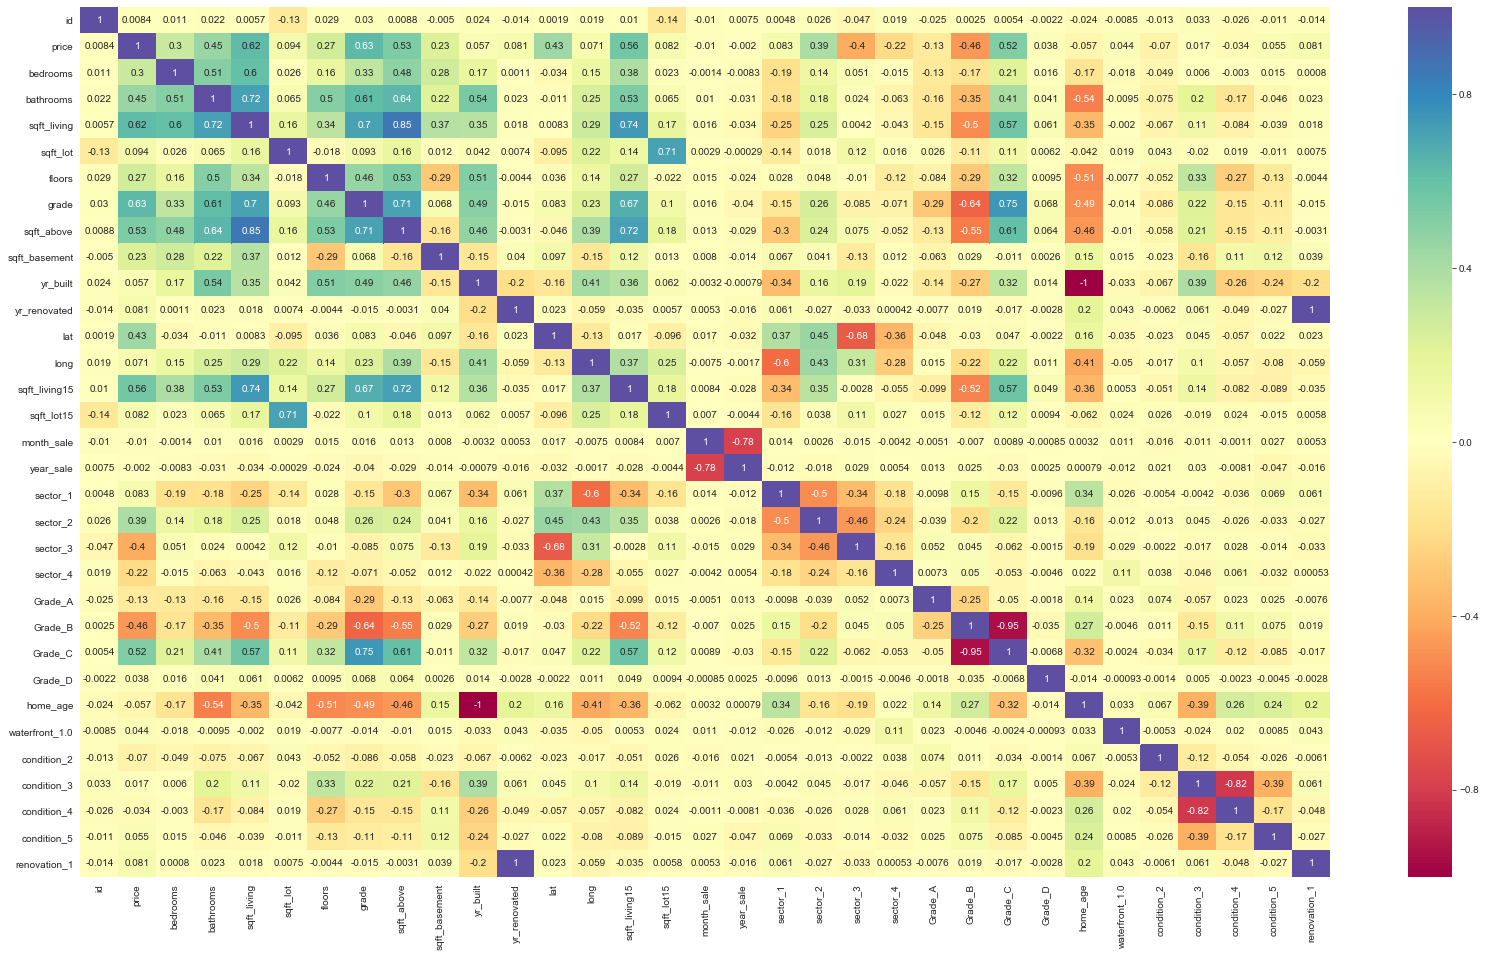

In [16]:
# Finally to complement the two previous functions, this heatmap correlates all 
# the columns and has their correlation coefficients on top of each. The values 
# From here I can already start determining which columns I will drop and which 
# I can work with

plt.figure(figsize=(28,16))
ax = sns.heatmap(df1.corr(), center=0, cmap='Spectral', annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation=0)
plt.show()

<b>Observations</b>: There is quite a high correlation coefficient between the condition_3 and 4, therefore I will have to drop one of both. Possibility of multicollinearity is also present between sqft_living, sqft_living15, sqft_above, grade, bathrooms, and bedrooms. 

High correlation to a point of collinearity as well between Grade_B and Grade_C. 

High possibility of collinearity between yr_built and home_age. This is understandable as one is the product of the other, so I won't be able to keep both and will have to drop one.

Following with the dummies creation, their data type is uint8, and this doesn't allow the linear regression to run. Therefore I will need to change them to int32 and also correct the waterfront_1.0 to waterfront_1 for the same reasons

In [17]:
for column in df1.columns:
    if df1[column].dtype == 'uint8':
        df1[column] = df1[column].astype('int32')
print(df1.dtypes)

id                  int64
price             float64
bedrooms            int64
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors            float64
grade               int64
sqft_above          int64
sqft_basement     float64
yr_built            int64
yr_renovated      float64
lat               float64
long              float64
sqft_living15       int64
sqft_lot15          int64
month_sale          int64
year_sale           int64
sector_1          float64
sector_2          float64
sector_3          float64
sector_4          float64
Grade_A           float64
Grade_B           float64
Grade_C           float64
Grade_D           float64
home_age            int64
waterfront_1.0      int32
condition_2         int32
condition_3         int32
condition_4         int32
condition_5         int32
renovation_1        int32
dtype: object


In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20240 entries, 0 to 21596
Data columns (total 33 columns):
id                20240 non-null int64
price             20240 non-null float64
bedrooms          20240 non-null int64
bathrooms         20240 non-null float64
sqft_living       20240 non-null int64
sqft_lot          20240 non-null int64
floors            20240 non-null float64
grade             20240 non-null int64
sqft_above        20240 non-null int64
sqft_basement     20240 non-null float64
yr_built          20240 non-null int64
yr_renovated      20240 non-null float64
lat               20240 non-null float64
long              20240 non-null float64
sqft_living15     20240 non-null int64
sqft_lot15        20240 non-null int64
month_sale        20240 non-null int64
year_sale         20240 non-null int64
sector_1          20240 non-null float64
sector_2          20240 non-null float64
sector_3          20240 non-null float64
sector_4          20240 non-null float64
Grade_A    

In [19]:
df2 = df1.copy() # df2 will be our dataframe for the modeling.

In [20]:
df2 = df2.rename(columns={'waterfront_1.0': 'waterfront_1'})

## Model 1: Fitting

From thee heatmap and the correlation values I can see that there are two variablea/features that I will need to drop for the model on top of the price (target) and the id. these are the condition_4 and the Grade_D, but for the base model I will leave it as it is and will only drop the price since it is our target. Then I will start running differeent tests

In [21]:
outcome = 'price'
x_cols = df2.drop([ 'price'], axis=1).columns
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

model = smf.ols(formula=formula, data=df2).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                   OLS                   Adj. R-squared:          0.722      
Dependent Variable:      price                 AIC:                     526936.1946
Date:                    2020-07-28 18:17      BIC:                     527181.5725
No. Observations:        20240                 Log-Likelihood:          -2.6344e+05
Df Model:                30                    F-statistic:             1750.      
Df Residuals:            20209                 Prob (F-statistic):      0.00       
R-squared:               0.722                 Scale:                   1.1843e+10 
-----------------------------------------------------------------------------------
                  Coef.       Std.Err.     t     P>|t|      [0.025        0.975]   
-----------------------------------------------------------------------------------
Intercept          -28.1307      2.6615 -10.5695 0.0000      -33.3475      -22.9140
id                  -0.0000      0.0000  -0.5429 0.5872       -0.0000        0.0000
bedrooms         -8561.7436   1147.3771  -7.4620 0.0000   -10810.6961    -6312.7911
bathrooms        23506.6049   1895.1888  12.4033 0.0000    19791.8807    27221.3291
sqft_living         63.8741     10.8356   5.8948 0.0000       42.6353       85.1128
sqft_lot             0.2823      0.0272  10.3620 0.0000        0.2289        0.3357
floors           18697.9288   2113.3885   8.8474 0.0000    14555.5153    22840.3423
grade            63761.2108   1590.7078  40.0835 0.0000    60643.2941    66879.1276
sqft_above          13.4641     10.8113   1.2454 0.2130       -7.7269       34.6551
sqft_basement        8.8271     10.7286   0.8228 0.4107      -12.2018       29.8560
yr_built        -29155.3816   2687.2850 -10.8494 0.0000   -34422.6788   -23888.0843
yr_renovated      2218.4074    272.4659   8.1420 0.0000     1684.3521     2752.4627
lat             154098.4296   9861.5603  15.6262 0.0000   134768.9689   173427.8903
long            -35616.9885   8535.7039  -4.1727 0.0000   -52347.6627   -18886.3143
sqft_living15       53.9929      2.0991  25.7224 0.0000       49.8786       58.1072
sqft_lot15          -0.0701      0.0417  -1.6800 0.0930       -0.1518        0.0117
month_sale         438.0423    395.2622   1.1082 0.2678     -336.7038     1212.7883
year_sale        23203.3751   2639.4501   8.7910 0.0000    18029.8381    28376.9121
sector_1         32890.9852  10509.1387   3.1298 0.0018    12292.2182    53489.7522
sector_2         24382.6629  10564.5979   2.3080 0.0210     3675.1914    45090.1344
sector_3       -112118.3159  10785.8128 -10.3950 0.0000  -133259.3866   -90977.2451
sector_4       -117482.6041  10997.9983 -10.6822 0.0000  -139039.5757   -95925.6325
Grade_A          62167.1503  13911.7669   4.4687 0.0000    34898.9551    89435.3454
Grade_B          14108.9512  12443.0773   1.1339 0.2569   -10280.4929    38498.3953
Grade_C          34795.5346  12438.0416   2.7975 0.0052    10415.9608    59175.1084
Grade_D        -111099.7668  36898.8464  -3.0109 0.0026  -183424.5085   -38775.0250
home_age        -27668.7280   2689.1282 -10.2891 0.0000   -32939.6381   -22397.8179
waterfront_1    191224.2748  13168.0862  14.5218 0.0000   165413.7544   217034.7953
condition_2      46868.6327  22723.7287   2.0625 0.0392     2328.2751    91408.9902
condition_3      74257.7816  21142.6089   3.5122 0.0004    32816.5477   115699.0155
condition_4     105617.9843  21147.4894   4.9944 0.0000    64167.1840   147068.7845
condition_5     136106.2061  21276.6639   6.3970 0.0000    94402.2134   177810.1987
renovation_1  -4386886.4043 543713.1423  -8.0684 0.0000 -5452608.4096 -3321164.3989
-----------------------------------------------------------------------------------
Omnibus:              1810.323        Durbin-Watson:           1.985               
Prob(Omnibus):        0.000  

### Model 1: Initial Refinement

There isn't much added for this initial refinement but a few categories that are being dropped which were identified mainly with the heatmap due to their high correlation values as being high candidates for collinearity. Still I will run a variance inflation factor (vif) later on to check for collinearity once again after a few more fittings.

In [29]:
outcome = 'price'
x_cols = df2.drop([ 'price', 'id', 'condition_4', 'Grade_D', 'sqft_above', 'sqft_basement', 'month_sale', 'sqft_lot15'], axis=1).columns
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

model = smf.ols(formula=formula, data=df2).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                   OLS                   Adj. R-squared:          0.721      
Dependent Variable:      price                 AIC:                     526957.1781
Date:                    2020-07-28 18:25      BIC:                     527155.0635
No. Observations:        20240                 Log-Likelihood:          -2.6345e+05
Df Model:                24                    F-statistic:             2183.      
Df Residuals:            20215                 Prob (F-statistic):      0.00       
R-squared:               0.722                 Scale:                   1.1859e+10 
-----------------------------------------------------------------------------------
                  Coef.       Std.Err.     t     P>|t|      [0.025        0.975]   
-----------------------------------------------------------------------------------
Intercept          -25.7921      1.7086 -15.0956 0.0000      -29.1411      -22.4431
bedrooms         -8381.6979   1146.2648  -7.3122 0.0000   -10628.4701    -6134.9257
bathrooms        22988.2915   1870.5140  12.2898 0.0000    19321.9320    26654.6510
sqft_living         75.4325      2.0951  36.0044 0.0000       71.3259       79.5390
sqft_lot             0.2531      0.0201  12.6209 0.0000        0.2138        0.2924
floors           20398.9883   1870.3388  10.9066 0.0000    16732.9721    24065.0045
grade            64106.9172   1589.0024  40.3441 0.0000    60992.3431    67221.4912
yr_built        -26791.8396   1724.3645 -15.5372 0.0000   -30171.7344   -23411.9449
yr_renovated      2200.9401    272.5700   8.0748 0.0000     1666.6807     2735.1994
lat             154318.2318   9856.6628  15.6562 0.0000   134998.3709   173638.0927
long            -34575.4802   8345.8436  -4.1428 0.0000   -50934.0125   -18216.9478
sqft_living15       54.0345      2.0762  26.0257 0.0000       49.9650       58.1041
year_sale        20889.1987   1640.2753  12.7352 0.0000    17674.1257    24104.2716
sector_1         33452.9685  10514.4272   3.1816 0.0015    12843.8359    54062.1011
sector_2         25292.5402  10569.8661   2.3929 0.0167     4574.7429    46010.3375
sector_3       -110637.9300  10783.8110 -10.2596 0.0000  -131775.0767   -89500.7833
sector_4       -116376.9612  10992.5429 -10.5869 0.0000  -137923.2394   -94830.6830
Grade_A         167007.7742  50009.2008   3.3395 0.0008    68985.6727   265029.8756
Grade_B         121692.7343  49137.3056   2.4766 0.0133    25379.6184   218005.8503
Grade_C         142921.7983  48905.5062   2.9224 0.0035    47063.0281   238780.5686
home_age        -25308.2271   1727.2400 -14.6524 0.0000   -28693.7579   -21922.6962
waterfront_1    189701.9171  13171.8124  14.4021 0.0000   163884.0934   215519.7408
condition_2     -57573.1136   8789.8230  -6.5500 0.0000   -74801.8816   -40344.3456
condition_3     -30622.4360   1926.6143 -15.8944 0.0000   -34398.7567   -26846.1153
condition_5      30870.4097   3192.7914   9.6688 0.0000    24612.2789    37128.5405
renovation_1  -4352111.8312 543920.9868  -8.0014 0.0000 -5418241.2098 -3285982.4527
-----------------------------------------------------------------------------------
Omnibus:               1799.204       Durbin-Watson:          1.984                
Prob(Omnibus):         0.000          Jarque-Bera (JB):       3552.582             
Skew:                  0.598          Prob(JB):               0.000                
Kurtosis:              4.667          Condition No.:          112921442901811707904
===================================================================================
* The condition number is large (1e+20). This might indicate             strong
multicollinearity or other numerical problems.
"""

Not much changed by dropping a series of selected categories. The p-values are all under 0.05 which is something that I was expecting after filtering the data using the correlation matrix and the heatmap as guides. This is a good starting point as it is a suggestion that most, if not all of those variables, can be substantially influential.  The R-square is not bad by being just over 0.7 but it is not the best, so I will work with this for the time being and see what the next steps will give and if it improves.

I will try on parallel now to do run a second model which will be using the vif to detect multicollinearity. Then I will compare both results and make a decision to which model I will keep on training:

### Model 1: Checking for Multicollinearity

Collinearity and multicollinearity has been initially addressed by looking at the correlation matrix and the heatmap using as guidelines the correlation coefficients and color coding. Multicollinearity was assessed by looking at the relationship between 3 or more variables. An additional test that can be done is the "variance inflation factor" (vif). Typically variables with a vif of 5 or greater (or more definitively 10 or greater) are displaying multicollinearity with other variables. Let's run a vif and compare it to what the previous fit is suggesting with all our p-values below the threshold of 0.05:

In [27]:
X = df2[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.7465005196969134),
 ('bathrooms', 3.0019002488497675),
 ('sqft_living', 4.464792859908347),
 ('sqft_lot', 1.107365207741177),
 ('floors', 1.7218773768012),
 ('grade', 4.598955467149131),
 ('yr_built', 19717882.063699715),
 ('yr_renovated', 14972.115105669007),
 ('lat', 3.303569758017205),
 ('long', 2.410416053077795),
 ('sqft_living15', 2.7724113156453933),
 ('year_sale', 1.0072282286146221),
 ('sector_1', 37.25571524514877),
 ('sector_2', 45.89200680539597),
 ('sector_3', 36.413329994354896),
 ('sector_4', 14.89451081153717),
 ('Grade_A', 54.53908915313289),
 ('Grade_B', 583.6418202967724),
 ('Grade_C', 541.9825892369213),
 ('home_age', 16604.364535430916),
 ('waterfront_1', 1.020586365124649),
 ('condition_2', 1.0341861078755314),
 ('condition_3', 1.4433329038137226),
 ('condition_5', 1.2245467345439889),
 ('renovation_1', 14970.564313638662)]

### Model 2: Alternative Model with Reduced Multicollinearity

While the p-values suggest that all of the current variables are impactful, the vif indicates that there is a large multicollinearity between some of our variables. Knowing this, it makes sense to fit again the model dropping the variables with a vif greater than 5. 

In [30]:
outcome = 'price'
x_cols = df2.drop(['price', 'id', 'yr_built', 'yr_renovated', 'sector_1', 'sector_2', 'sector_3', 'sector_4', 'Grade_A', 'Grade_B', 'Grade_C', 'home_age', 'renovation_1'], axis=1).columns
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

model = smf.ols(formula=formula, data=df2).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                     OLS                    Adj. R-squared:           0.656      
Dependent Variable:        price                  AIC:                      531199.8083
Date:                      2020-07-28 18:28       BIC:                      531366.0321
No. Observations:          20240                  Log-Likelihood:           -2.6558e+05
Df Model:                  20                     F-statistic:              1933.      
Df Residuals:              20219                  Prob (F-statistic):       0.00       
R-squared:                 0.657                  Scale:                    1.4627e+10 
---------------------------------------------------------------------------------------
                  Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
---------------------------------------------------------------------------------------
Intercept     -87328308.5531 5973223.7843 -14.6200 0.0000 -99036312.9145 -75620304.1917
bedrooms          -9508.9037    1258.8611  -7.5536 0.0000    -11976.3739     -7041.4335
bathrooms         -1682.4472    1967.8227  -0.8550 0.3926     -5539.5397      2174.6452
sqft_living          85.1247      12.0325   7.0746 0.0000        61.5401       108.7093
sqft_lot              0.3057       0.0302  10.1312 0.0000         0.2466         0.3649
floors            12415.6331    2233.7544   5.5582 0.0000      8037.2929     16793.9734
grade             60531.1703    1349.7812  44.8452 0.0000     57885.4894     63176.8511
sqft_above            1.7526      12.0033   0.1460 0.8839       -21.7748        25.2800
sqft_basement         9.3230      11.9223   0.7820 0.4342       -14.0456        32.6916
lat              578757.7547    6226.9448  92.9441 0.0000    566552.4366    590963.0727
long            -126036.8012    6921.9296 -18.2083 0.0000   -139604.3460   -112469.2563
sqft_living15        55.7128       2.2876  24.3539 0.0000        51.2289        60.1968
sqft_lot15           -0.1347       0.0461  -2.9196 0.0035        -0.2251        -0.0443
month_sale          325.4237     439.1529   0.7410 0.4587      -535.3516      1186.1990
year_sale         21901.5716    2931.9073   7.4701 0.0000     16154.7948     27648.3484
Grade_D         -101914.1663   54291.6483  -1.8772 0.0605   -208330.2120      4501.8794
waterfront_1     189443.0506   14539.8135  13.0293 0.0000    160943.8337    217942.2675
condition_2       13051.6180   25200.1422   0.5179 0.6045    -36342.7099     62445.9459
condition_3       16980.8677   23388.4210   0.7260 0.4678    -28862.3395     62824.0748
condition_4       61321.3835   23406.5335   2.6198 0.0088     15442.6743    107200.0926
condition_5      111373.4326   23554.7825   4.7283 0.0000     65204.1434    157542.7218
---------------------------------------------------------------------------------------
Omnibus:                   1804.721             Durbin-Watson:                1.990    
Prob(Omnibus):             0.000                Jarque-Bera (JB):             2875.615 
Skew:                      0.671                Prob(JB):                     0.000    
Kurtosis:                  4.269                Condition No.:                344364001
=======================================================================================
* The condition number is large (3e+08). This might indicate             strong
multicollinearity or other numerical problems.
"""

That was not enough as no there are a series of variables with p-values over 0.05. So I will need to deal with these:

In [33]:
outcome = 'price'
x_cols = df2.drop(['price', 'id', 'yr_built', 'yr_renovated', 'sector_1', 'sector_2', 'sector_3', 'sector_4', 'Grade_A', 'Grade_B', 'Grade_C', 'home_age', 'renovation_1', 'bathrooms', 'sqft_above', 'sqft_basement', 'month_sale', 'Grade_D', 'condition_2', 'condition_3'], axis=1).columns
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

model = smf.ols(formula=formula, data=df2).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                     OLS                    Adj. R-squared:           0.656      
Dependent Variable:        price                  AIC:                      531198.3062
Date:                      2020-07-28 18:32       BIC:                      531309.1220
No. Observations:          20240                  Log-Likelihood:           -2.6559e+05
Df Model:                  13                     F-statistic:              2972.      
Df Residuals:              20226                  Prob (F-statistic):       0.00       
R-squared:                 0.656                  Scale:                    1.4631e+10 
---------------------------------------------------------------------------------------
                  Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
---------------------------------------------------------------------------------------
Intercept     -84469814.0649 3770608.6341 -22.4022 0.0000 -91860513.4614 -77079114.6683
bedrooms          -9588.3725    1237.1692  -7.7503 0.0000    -12013.3248     -7163.4202
sqft_living          89.2198       2.1265  41.9567 0.0000        85.0517        93.3878
sqft_lot              0.3038       0.0301  10.0777 0.0000         0.2447         0.3629
floors             9575.6286    1862.9897   5.1399 0.0000      5924.0174     13227.2398
grade             59974.3504    1319.1749  45.4635 0.0000     57388.6603     62560.0405
lat              581040.0613    6165.7296  94.2370 0.0000    568954.7302    593125.3923
long            -130511.3462    6688.0299 -19.5142 0.0000   -143620.4284   -117402.2640
sqft_living15        54.7584       2.2531  24.3035 0.0000        50.3421        59.1746
sqft_lot15           -0.1344       0.0461  -2.9152 0.0036        -0.2247        -0.0440
year_sale         20168.6855    1821.2386  11.0742 0.0000     16598.9097     23738.4612
waterfront_1     189656.3344   14538.0481  13.0455 0.0000    161160.5785    218152.0904
condition_4       44744.9806    2058.1487  21.7404 0.0000     40710.8418     48779.1193
condition_5       94951.8464    3348.8999  28.3531 0.0000     88387.7303    101515.9625
---------------------------------------------------------------------------------------
Omnibus:                   1812.406             Durbin-Watson:                1.990    
Prob(Omnibus):             0.000                Jarque-Bera (JB):             2889.355 
Skew:                      0.673                Prob(JB):                     0.000    
Kurtosis:                  4.271                Condition No.:                217322619
=======================================================================================
* The condition number is large (2e+08). This might indicate             strong
multicollinearity or other numerical problems.
"""

No I took care of all of the high vif and the model has a slightly lower R-square but nothing dramatical. However, let's keep in mind that this is a modeling choice and not a definitely step. Clearly there are advantages and tradebacks to this approach compare to the previous one. This is simple to see, if we remove the weight components, the model's performance is substantially diminished (look at the R-squared), but the multicollinearity has been reduced. Lets look at the Normality and the errors and make a decision based on that:

### Model 2: Associated Errors and Residual Normality 

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [36]:
data = df2
y = data['price']
X = data.drop(['price', 'id', 'sqft_living', 'condition_4', 'Grade_D', 'bathrooms', 'sqft_lot15', 'bedrooms', 'floors', 'yr_built', 'lat', 'long', 'sqft_living15', 'year_sale'], axis = 1)

In [37]:
# create data sets with an 80/20 split - train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [38]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 12518200148.748669
Test Mean Squarred Error: 12947512431.966793


In [39]:
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
print('Train Root Mean Squarred Error:', rmse_train)
print('Test Root Mean Squarred Error:', rmse_test)

Train Root Mean Squarred Error: 111884.76280865357
Test Root Mean Squarred Error: 113787.13649603278


Now that this model has been fitted, I need to check that it's residual follow a normal (Gaussian) distribution. For this purpose I will use the following probability plot:

In [40]:
y_predicted = linreg.predict(X)

In [41]:
residuals = y - y_predicted

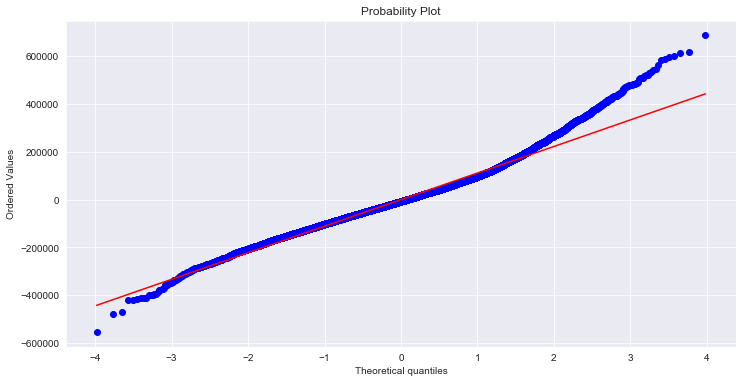

In [42]:
from scipy.stats import probplot

plt.figure(figsize=(12,6))
_ = probplot(residuals, plot=plt)

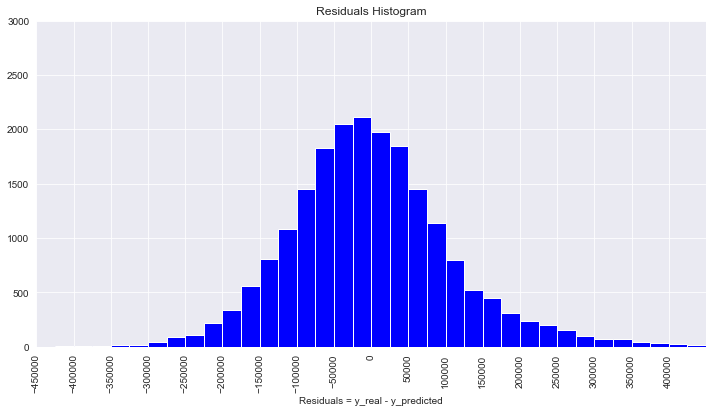

In [43]:
# Histogram for residuals

    color = 'Blue'
    plt.figure(figsize=(12,6))
    plt.hist(residuals, histtype = 'bar', range = (-500000, 500000),bins = 40, color=color)
    plt.ylim(0,3000)
    plt.xlim(-450000, 450000)
    plt.xticks((range(-450000,450000, 50000)), rotation = 'vertical')
    plt.xlabel('Residuals = y_real - y_predicted')
    plt.title('Residuals Histogram')
    plt.show()

Observations: the errors are not bad at around 113,000 $ and the residuals normality is not bad either as the probability plot and the residuals histogram are suggesting. The histogram in particular shows an almost Gaussian distribution which is "slightly skewed" with a value of 0.673. The Kurstosis value of 4.271, but even when it is greater than 3, I would classify it as Mesokurtic as it is not too far from 3, but this is only my interpretation.

At this point though, I am not convinced about this second option as I have eliminated too many variables that in my mind can be good predictables. So even when I will keep Model_1, we must not forget that that model suffers from multicollinearity which could impact its interpretation. I will run more refinements on the Model 1, calculate it's associated error and check for normality to make a proper decision on which model to keep

## Model 1: Continued Refinement

### Log-Transformations 

To continue with the model refinement I will proceed to choose some of the variables/features to log transform them. I will star by defining them, followed by log_transforming them, dropping the original ones from the initial model, and finally concatenating the new log_transformed ones to the previous dataframe. 

In [44]:
norm_candidates = ['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_basement']

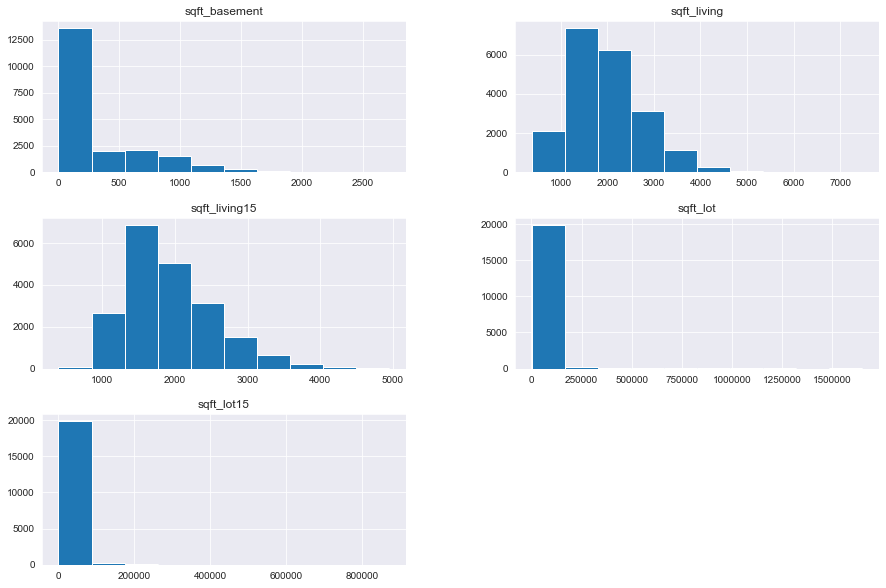

In [45]:
df2[norm_candidates].hist(figsize=(15,10));

Unfortunately the variable "sqft_basement' will not be in the candidates to log_transform as there is a high number of rows with "0" in place, and log 0 is undefined. I might try to do another transform if needed later on, but I might not take this variable into account as it is known by now that sqft_living = sqft_above + sqft_basement

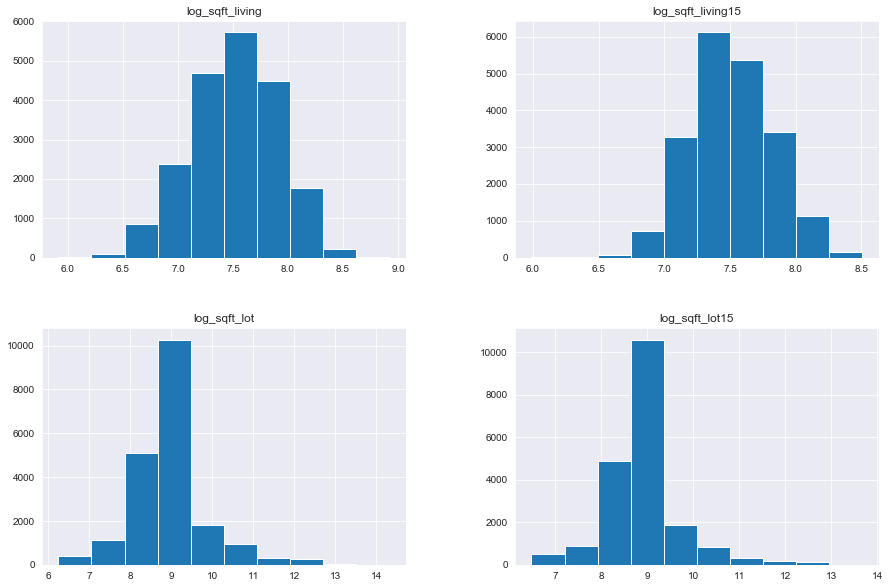

In [46]:
df_log = df2.copy()

log_sqft_living = np.log(df_log['sqft_living'])
log_sqft_living15 = np.log(df_log['sqft_living15'])
log_sqft_lot = np.log(df_log['sqft_lot'])
log_sqft_lot15 = np.log(df_log['sqft_lot15'])

logs = ['log_sqft_living', 'log_sqft_living15', 'log_sqft_lot', 'log_sqft_lot15']

df_log['log_sqft_living'] = log_sqft_living
df_log['log_sqft_living15'] = log_sqft_living15
df_log['log_sqft_lot'] = log_sqft_lot
df_log['log_sqft_lot15'] = log_sqft_lot15

df_log[logs].hist(figsize=(15,10));

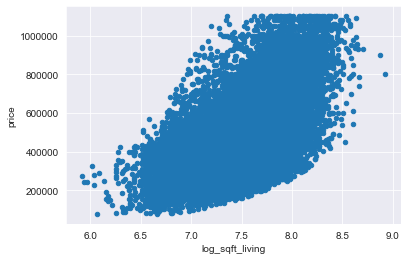

In [47]:
df_log.plot(kind = 'scatter', x = 'log_sqft_living', y = 'price')

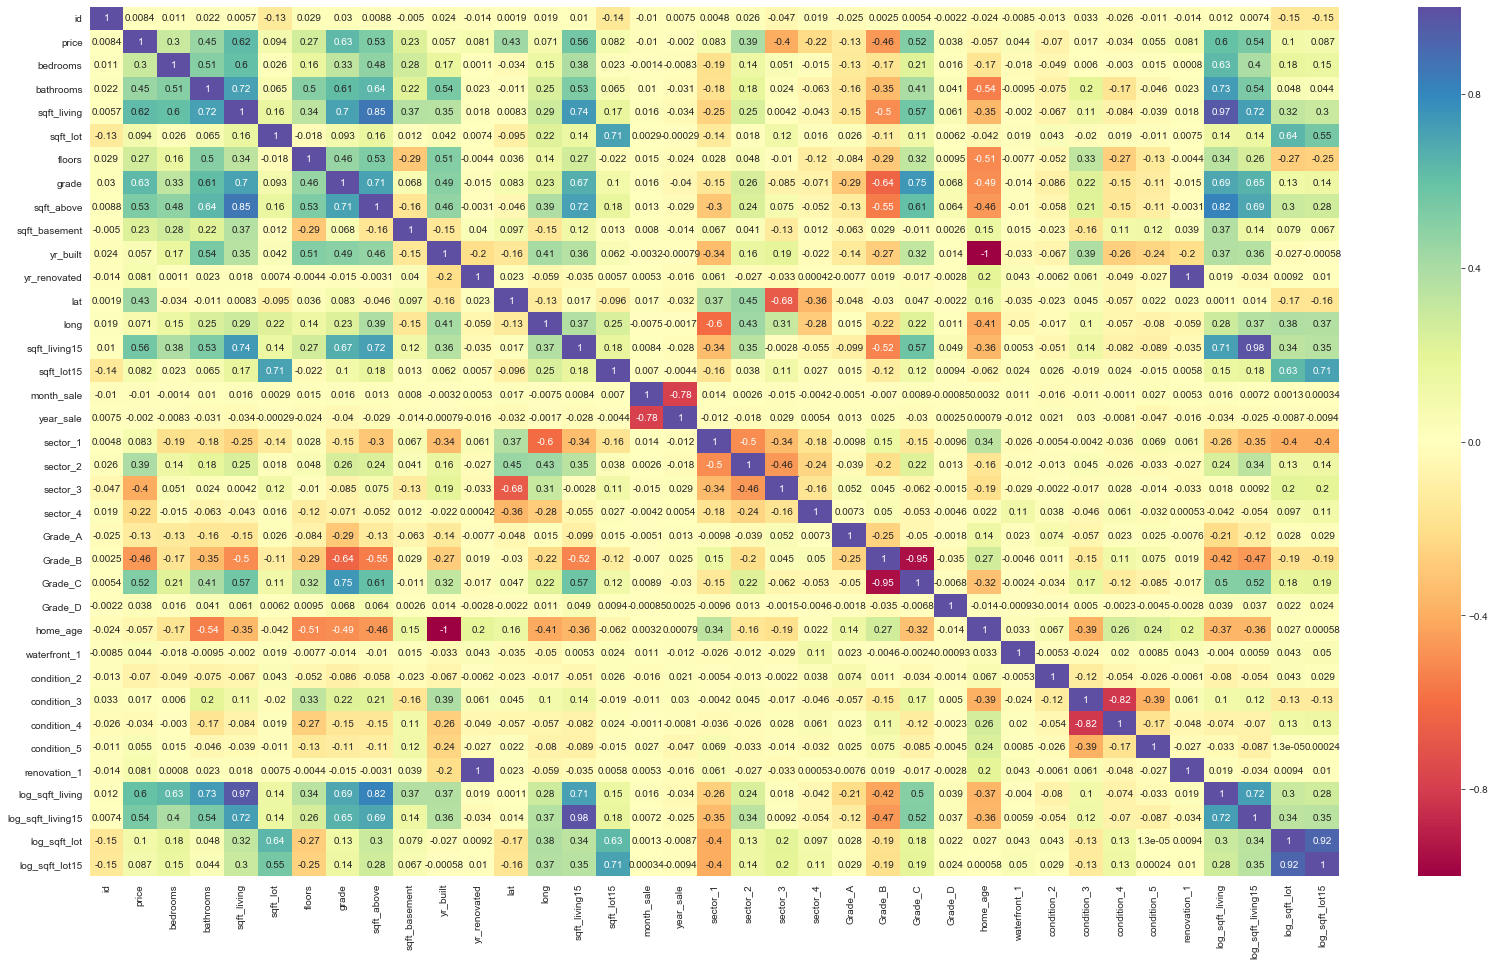

In [48]:
plt.figure(figsize=(28,16))
ax = sns.heatmap(df_log.corr(), center=0, cmap='Spectral', annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation=0)
plt.show()

There is still a high correlation between the following pairs:
* condition_3 and condition_4 
* log_sqft_lot and log_sqft_lot15. 
* log_sqft_living and log_sqft_living15 but this one is not surpassing the .75 threshold

To avoid collinearity I will have to drop one of each when fitting the model

In [49]:
# I will run a quick lost of the columns available for my own benefit of checking them

df_log.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'month_sale', 'year_sale', 'sector_1', 'sector_2', 'sector_3',
       'sector_4', 'Grade_A', 'Grade_B', 'Grade_C', 'Grade_D', 'home_age',
       'waterfront_1', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'renovation_1', 'log_sqft_living', 'log_sqft_living15',
       'log_sqft_lot', 'log_sqft_lot15'],
      dtype='object')

In [50]:
df_log = df_log.drop(['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'condition_4'], axis=1)
df_log.head()

,id,price,bedrooms,bathrooms,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,month_sale,year_sale,sector_1,sector_2,sector_3,sector_4,Grade_A,Grade_B,Grade_C,Grade_D,home_age,waterfront_1,condition_2,condition_3,condition_5,renovation_1,log_sqft_living,log_sqft_living15,log_sqft_lot,log_sqft_lot15
0,7129300520,221900.0,3,1.00,1.0,7,1180,0.0,1955,0.0,47.5112,-122.257,10,2014,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,65,0,0,1,0,0,7.073270,7.200425,8.639411,8.639411
1,6414100192,538000.0,3,2.25,2.0,7,2170,400.0,1951,1991.0,47.7210,-122.319,12,2014,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,69,0,0,1,0,1,7.851661,7.432484,8.887653,8.941022
2,5631500400,180000.0,2,1.00,1.0,6,770,0.0,1933,0.0,47.7379,-122.233,2,2015,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,87,0,0,1,0,0,6.646391,7.908387,9.210340,8.994917
3,2487200875,604000.0,4,3.00,1.0,7,1050,910.0,1965,0.0,47.5208,-122.393,12,2014,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55,0,0,0,1,0,7.580700,7.215240,8.517193,8.517193
4,1954400510,510000.0,3,2.00,1.0,8,1680,0.0,1987,0.0,47.6168,-122.045,2,2015,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,33,0,0,1,0,0,7.426549,7.495542,8.997147,8.923058


At this point, with the log_tranformed variables in the new dataframe, I will run another heatmap with correlation coefficients to compare it with the previous one and address possible collinearity and multicollinearity again

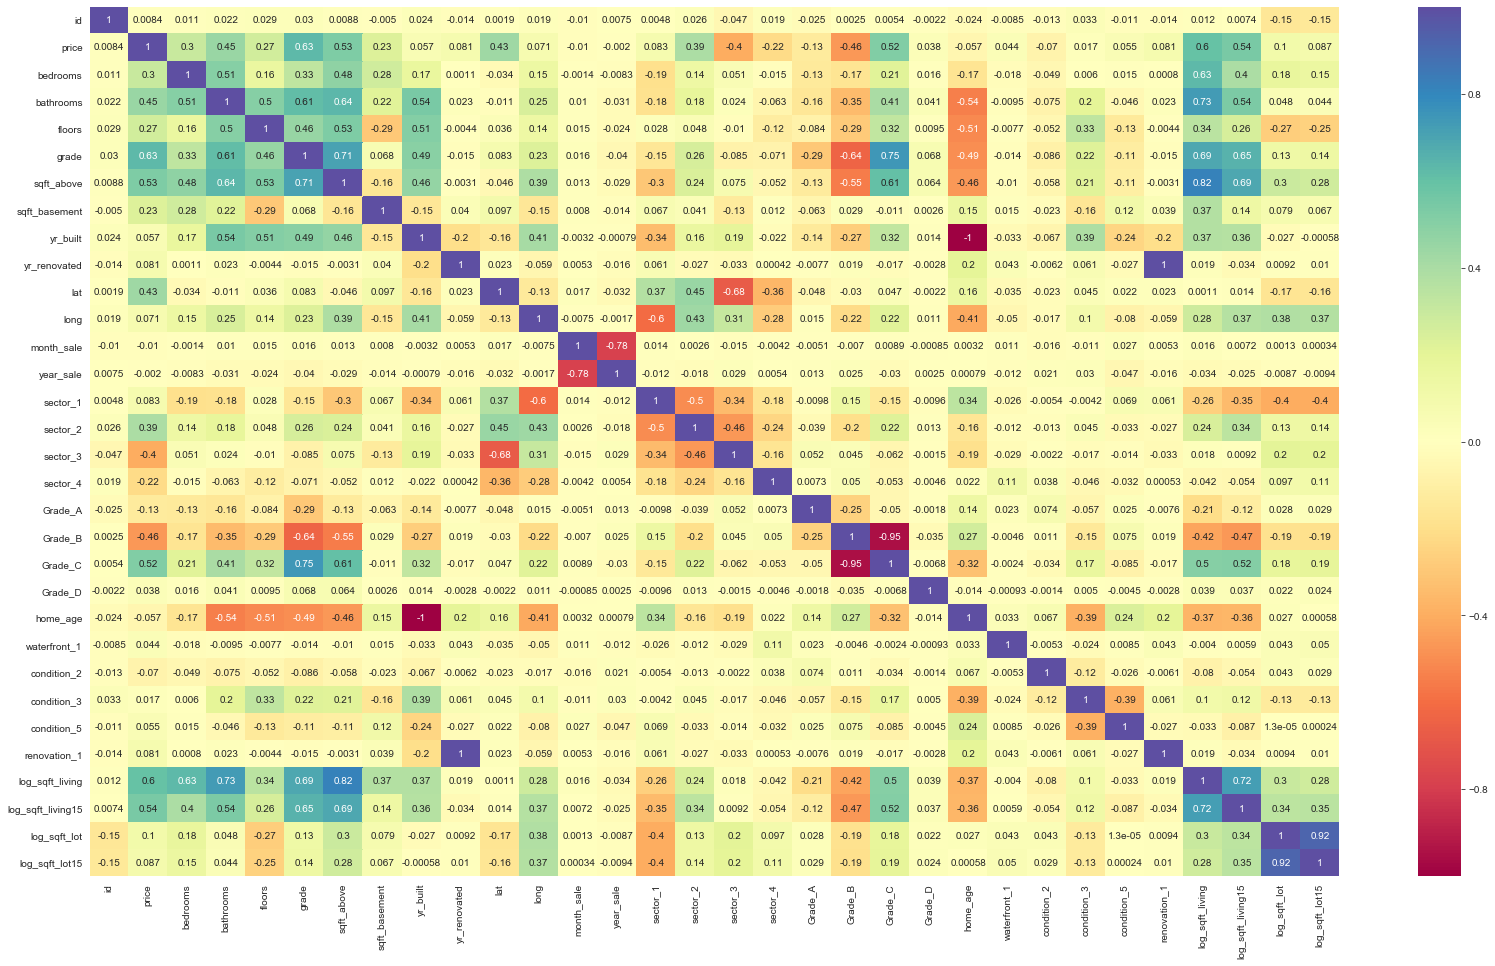

In [51]:
plt.figure(figsize=(28,16))
ax = sns.heatmap(df_log.corr(), center=0, cmap='Spectral', annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation=0)
plt.show()

In [52]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20240 entries, 0 to 21596
Data columns (total 32 columns):
id                   20240 non-null int64
price                20240 non-null float64
bedrooms             20240 non-null int64
bathrooms            20240 non-null float64
floors               20240 non-null float64
grade                20240 non-null int64
sqft_above           20240 non-null int64
sqft_basement        20240 non-null float64
yr_built             20240 non-null int64
yr_renovated         20240 non-null float64
lat                  20240 non-null float64
long                 20240 non-null float64
month_sale           20240 non-null int64
year_sale            20240 non-null int64
sector_1             20240 non-null float64
sector_2             20240 non-null float64
sector_3             20240 non-null float64
sector_4             20240 non-null float64
Grade_A              20240 non-null float64
Grade_B              20240 non-null float64
Grade_C              2024

In [56]:
x_cols = df_log.drop(['price', 'id', 'sector_2', 'Grade_B', 'Grade_D', 'month_sale', 'long'], axis=1).columns
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

model = smf.ols(formula=formula, data=df_log).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                     OLS                    Adj. R-squared:           0.720      
Dependent Variable:        price                  AIC:                      527042.6899
Date:                      2020-07-28 18:42       BIC:                      527240.5753
No. Observations:          20240                  Log-Likelihood:           -2.6350e+05
Df Model:                  24                     F-statistic:              2171.      
Df Residuals:              20215                  Prob (F-statistic):       0.00       
R-squared:                 0.720                  Scale:                    1.1909e+10 
---------------------------------------------------------------------------------------
                      Coef.       Std.Err.     t     P>|t|      [0.025        0.975]   
---------------------------------------------------------------------------------------
Intercept              -24.0453      1.6430 -14.6348 0.0000      -27.2658      -20.8248
bedrooms            -10956.1872   1168.3243  -9.3777 0.0000   -13246.1980    -8666.1765
bathrooms            21685.5122   1910.4216  11.3512 0.0000    17940.9305    25430.0938
floors               16575.1530   2241.7471   7.3939 0.0000    12181.1465    20969.1596
grade                62079.6864   1604.1384  38.6997 0.0000    58935.4446    65223.9282
sqft_above              58.6536      4.1997  13.9660 0.0000       50.4218       66.8854
sqft_basement           51.1841      4.5369  11.2818 0.0000       42.2915       60.0767
yr_built            -25034.7068   1659.3119 -15.0874 0.0000   -28287.0931   -21782.3205
yr_renovated          2210.2394    273.1979   8.0902 0.0000     1674.7492     2745.7295
lat                 153266.6669   9908.3537  15.4684 0.0000   133845.4878   172687.8461
year_sale            20849.0526   1643.7543  12.6838 0.0000    17627.1604    24070.9447
sector_1             16535.4090   2270.5775   7.2825 0.0000    12084.8924    20985.9257
sector_3           -135484.0908   3228.2226 -41.9686 0.0000  -141811.6697  -129156.5118
sector_4           -133817.9438   3981.2358 -33.6122 0.0000  -141621.4898  -126014.3977
Grade_A              56057.1630   7563.9144   7.4111 0.0000    41231.2756    70883.0505
Grade_C              33542.7376   3497.8529   9.5895 0.0000    26686.6614    40398.8139
home_age            -23536.8139   1659.8567 -14.1800 0.0000   -26790.2679   -20283.3598
waterfront_1        194973.1859  13206.8382  14.7630 0.0000   169086.7087   220859.6631
condition_2         -53029.5439   8817.7852  -6.0139 0.0000   -70313.1201   -35745.9677
condition_3         -30843.8041   1940.9202 -15.8913 0.0000   -34648.1655   -27039.4427
condition_5          31742.0985   3202.8903   9.9105 0.0000    25464.1729    38020.0241
renovation_1      -4370223.3287 545174.2157  -8.0162 0.0000 -5438809.1379 -3301637.5195
log_sqft_living      47407.0384   8347.1119   5.6795 0.0000    31046.0201    63768.0566
log_sqft_living15   103037.4506   4071.2774  25.3084 0.0000    95057.4158   111017.4854
log_sqft_lot         14935.8481   2258.3906   6.6135 0.0000    10509.2187    19362.4774
log_sqft_lot15      -15763.6950   2454.0259  -6.4236 0.0000   -20573.7853   -10953.6047
---------------------------------------------------------------------------------------
Omnibus:                1764.059         Durbin-Watson:            1.982               
Prob(Omnibus):          0.000            Jarque-Bera (JB):         3374.326            
Skew:                   0.598            Prob(JB):                 0.000               
Kurtosis:               4.603            Condition No.:            11127985243574280192
=======================================================================================
* The condition number is large (1e+19). This might indicate             strong
multicollinearity or other 

The model has not increased it's R_squared, but overall it seems ok as all the p-values are below 0.05. Still remember that from the vif tests that I ran it is clear that this model will suffer from multicollinearity and this might affect up to a certain degree my interpretations. 

There is not much that I can do at this point but to look at the associated errors and normality

### Model 1: Associated Errors and Residual Normality

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

data = df_log
y = data['price']
X = data.drop(['price', 'id'], axis = 1)

In [58]:
# create data sets with an 80/20 split - train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [59]:
len(y_test)

4048

In [60]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 11956730950.776506
Test Mean Squarred Error: 11638046095.39921


In [61]:
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
print('Train Root Mean Squarred Error:', rmse_train)
print('Test Root Mean Squarred Error:', rmse_test)

Train Root Mean Squarred Error: 109346.83786363695
Test Root Mean Squarred Error: 107879.77611859978


The associated errors are considerably smaller by having an mse of 116758 dollars compared to the 143358 Dollars from Model 2, and the R_square is considerably higher as well going from 0.532 to 0.679 with a difference of 0.147 between them.

In [62]:
y_predicted = linreg.predict(X)

In [63]:
residuals = y -y_predicted

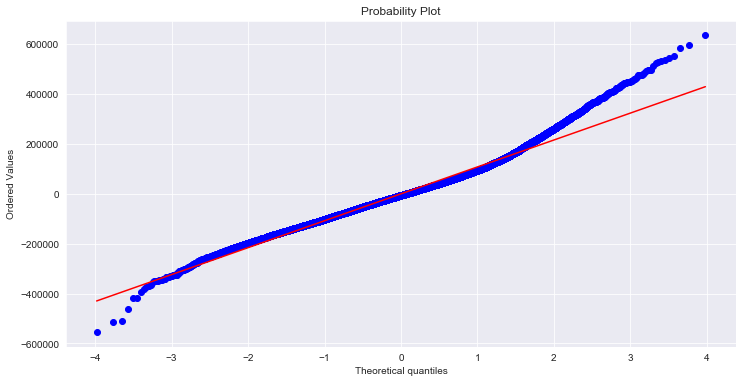

In [64]:
from scipy.stats import probplot
plt.figure(figsize=(12,6))
_ = probplot(residuals, plot=plt)

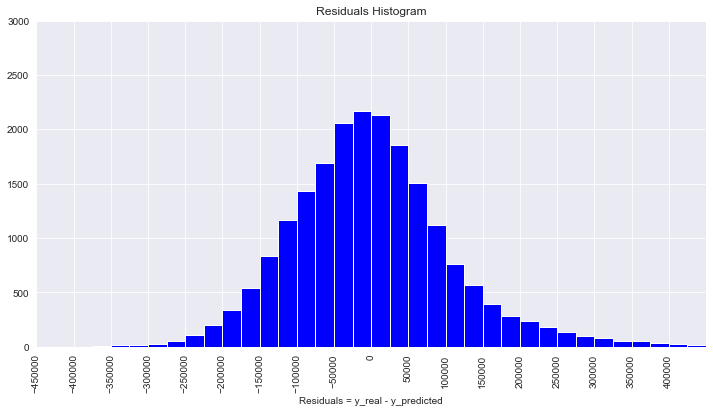

In [65]:
# Histogram for residuals

    color = 'Blue'
    plt.figure(figsize=(12,6))
    plt.hist(residuals, histtype = 'bar', range = (-500000, 500000),bins = 40, color=color)
    plt.ylim(0,3000)
    plt.xlim(-450000, 450000)
    plt.xticks((range(-450000,450000, 50000)), rotation = 'vertical')
    plt.xlabel('Residuals = y_real - y_predicted')
    plt.title('Residuals Histogram')
    plt.show()

The probability plot and the residual histogram are very close to each other. It is hard to see the difference between the two probability plots. For the histograms the main difference are the Skewness and the Kurtosis. Model 1 has a skewness of 0.544, so it is slightly less skewed to the right than Model 2, and it has a Kurtosis of 4.389 which suggest it is Leptokurtic, although the difference between one and the other is not too big. 

As commented above, I will keep Model 1 since it's R_square suggests it is outperforming Model 2. If time permits it, I will try to work more on Model 2 with other refinements but for the time being I'll stick to Model 1.

The next plot will give us an idea of the actual/real versus the predicted values:

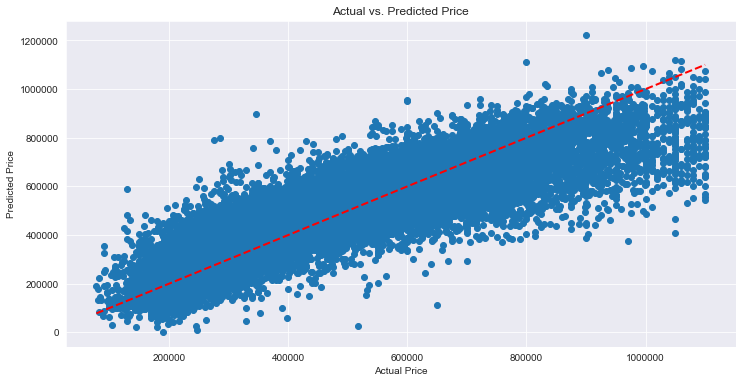

In [66]:
from sklearn.model_selection import cross_val_predict

predicted = cross_val_predict(linreg, X, y, cv=10)

fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax.set_title('Actual vs. Predicted Price')
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
plt.show()

The "Actual vs. Predicted Price" plot suggests that the model is acceptable up to about 600 thousand Dollars, but afterwards, the error increases. Maybe more refinement will be needed, or exploring other options by dealing with the multicollinearity is a better way. 

It is important to keep in mind that I put a threshold at 1.1 million $ and even though I tested the 1.2 and 1.3 million Dollars thresholds, not many differences where found. Maybe an alternative could be increasing the numbers of sectors (?) or treating this problem by zipcodes which would bee my preferred approach although we have been indicated not to do so due to the large number (70). 

Another option which I tested on a separate notebook is to focus the cleaning on eliminating the outliers by using the 3 standard deviation rule. This reduces the number of samples to just under 20000 which is not a a big percentage. However the R-squared of this model was considerably lower. Again, maybe more time dedicated to that model (Model 3) would give better results.

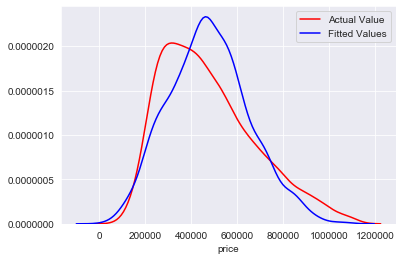

In [67]:
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_hat_test, hist=False, color="b", label="Fitted Values" , ax=ax1)

As mentioned above, and as this plot suggests, after around 600000 Dollars the model is not great. In fact, after around 500000 Dollars there is the possibility of a strong mismatch as the blue curve shows compared to the actual value (in red).

### Model 1: Further Refinement

As a final attempt to refine Model 1 I will look at the price range distribution and see if by lowering the threshold to 1 million dollars I can improve the model and if so, how much will my value range be affected in terms of percentage.

for this purpose I'll first look at the price distribution on a histogram:

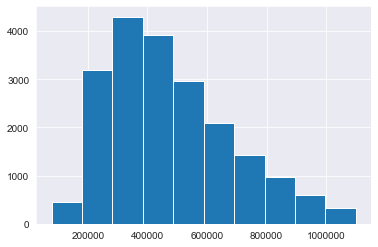

In [68]:
df_log.price.hist()

In [69]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df_log.price.quantile(q=q)))

0.8 percentile: 650000.0
0.81 percentile: 660000.0
0.82 percentile: 674950.0
0.83 percentile: 685000.0
0.84 percentile: 699000.0
0.85 percentile: 710000.0
0.86 percentile: 724270.0000000005
0.87 percentile: 735000.0
0.88 percentile: 750000.0
0.89 percentile: 765000.0
0.9 percentile: 780000.0
0.91 percentile: 799696.0000000007
0.92 percentile: 815000.0
0.93 percentile: 835000.0
0.94 percentile: 855000.0
0.95 percentile: 880000.0
0.96 percentile: 910000.0
0.97 percentile: 940829.9999999981
0.98 percentile: 979700.0
0.99 percentile: 1040000.0


In [70]:
orig_tot = len(df_log)
df_log = df_log[df_log.price < 1000000] # Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df_log))/orig_tot)
#df_log.price = df_log.price.map(np.log) # Applying a log transformation
train, test = train_test_split(df_log)

# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=df_log).fit()
model.summary()

Percent removed: 0.015069169960474308


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     2094.
Date:                Tue, 28 Jul 2020   Prob (F-statistic):               0.00
Time:                        18:44:37   Log-Likelihood:            -2.5856e+05
No. Observations:               19935   AIC:                         5.172e+05
Df Residuals:                   19910   BIC:                         5.174e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -22.9215      1.577    -14.531      0.000     -26.013     -19.830
bedrooms          -1.003e+04   1123.785     -8.923      0.000   -1.22e+04   -7824.716
bathrooms          2.016e+04   1847.322     10.913      0.000    1.65e+04    2.38e+04
floors              1.56e+04   2158.319      7.227      0.000    1.14e+04    1.98e+04
grade              5.991e+04   1556.453     38.491      0.000    5.69e+04     6.3e+04
sqft_above           50.0919      4.144     12.088      0.000      41.969      58.214
sqft_basement        39.7330      4.443      8.942      0.000      31.024      48.442
yr_built          -2.386e+04   1593.099    -14.978      0.000    -2.7e+04   -2.07e+04
yr_renovated       1990.4892    263.786      7.546      0.000    1473.448    2507.531
lat                 1.56e+05   9482.522     16.451      0.000    1.37e+05    1.75e+05
year_sale          1.959e+04   1578.097     12.413      0.000    1.65e+04    2.27e+04
sector_1           1.649e+04   2184.035      7.549      0.000    1.22e+04    2.08e+04
sector_3          -1.319e+05   3088.226    -42.718      0.000   -1.38e+05   -1.26e+05
sector_4          -1.302e+05   3806.214    -34.216      0.000   -1.38e+05   -1.23e+05
Grade_A            5.366e+04   7220.273      7.431      0.000    3.95e+04    6.78e+04
Grade_C            2.901e+04   3404.344      8.522      0.000    2.23e+04    3.57e+04
home_age          -2.244e+04   1593.575    -14.081      0.000   -2.56e+04   -1.93e+04
waterfront_1       1.925e+05   1.29e+04     14.969      0.000    1.67e+05    2.18e+05
condition_2       -5.172e+04   8403.717     -6.155      0.000   -6.82e+04   -3.53e+04
condition_3       -2.902e+04   1861.617    -15.591      0.000   -3.27e+04   -2.54e+04
condition_5        2.846e+04   3088.295      9.215      0.000    2.24e+04    3.45e+04
renovation_1      -3.936e+06   5.26e+05     -7.478      0.000   -4.97e+06    -2.9e+06
log_sqft_living    5.942e+04   8145.605      7.295      0.000    4.35e+04    7.54e+04
log_sqft_living15  9.998e+04   3925.507     25.471      0.000    9.23e+04    1.08e+05
log_sqft_lot       1.488e+04   2169.575      6.861      0.000    1.06e+04    1.91e+04
log_sqft_lot15    -1.504e+04   2355.439     -6.384      0.000   -1.97e+04   -1.04e+04
==============================================================================
Omnibus:                     1205.322   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2029.748
Skew:                           0.480   Prob(JB):                         0.00
Kurtosis:                       4.233   Cond. No.                     7.87e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smal

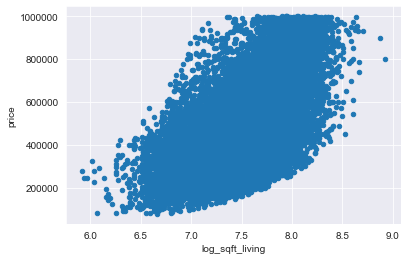

In [71]:
df_log.plot(kind = 'scatter', x = 'log_sqft_living', y = 'price')

### Model 1: Final Errors & Residuals

In [72]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 11956730950.776506
Test Mean Squarred Error: 11638046095.39921


In [73]:
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
print('Train Root Mean Squarred Error:', rmse_train)
print('Test Root Mean Squarred Error:', rmse_test)

Train Root Mean Squarred Error: 109346.83786363695
Test Root Mean Squarred Error: 107879.77611859978


The mse didn't change at all, and the R-squared is the same, so we will stop the testing here to avoid over-fitting it 

Comments on the probabilities and residual distribution are below after both plots

In [74]:
y_predicted = linreg.predict(X)

In [75]:
residuals = y -y_predicted

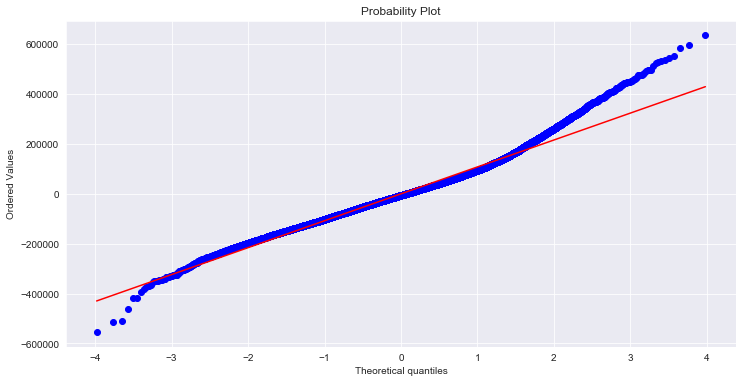

In [76]:
plt.figure(figsize=(12,6))
_ = probplot(residuals, plot=plt)

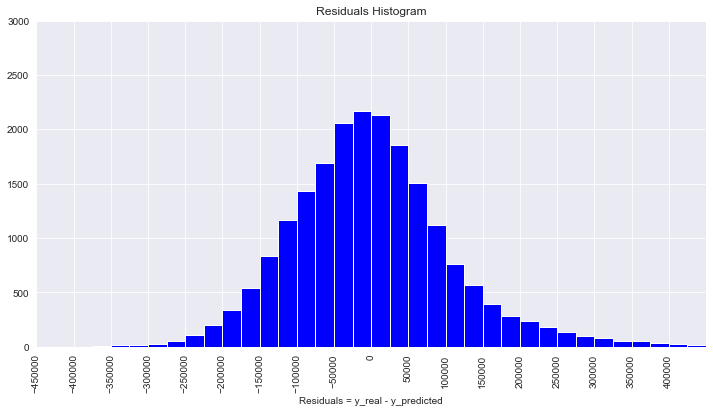

In [77]:
# Histogram for residuals

    color = 'Blue'
    plt.figure(figsize=(12,6))
    plt.hist(residuals, histtype = 'bar', range = (-500000, 500000),bins = 40, color=color)
    plt.ylim(0,3000)
    plt.xlim(-450000, 450000)
    plt.xticks((range(-450000,450000, 50000)), rotation = 'vertical')
    plt.xlabel('Residuals = y_real - y_predicted')
    plt.title('Residuals Histogram')
    plt.show()

The probability plot is almost the same as before as well as the residuals histogram. The skewness had a slight improvement changing to 0.443 as well as the Kurtosis to 4.113, so not much change with the small improvements achieved . 

Finally the Actual vs. Predicted Price plot is below, which again suggest that not much has changed, with good predictions up to around 600000 Dollars.

Additional comments on the README


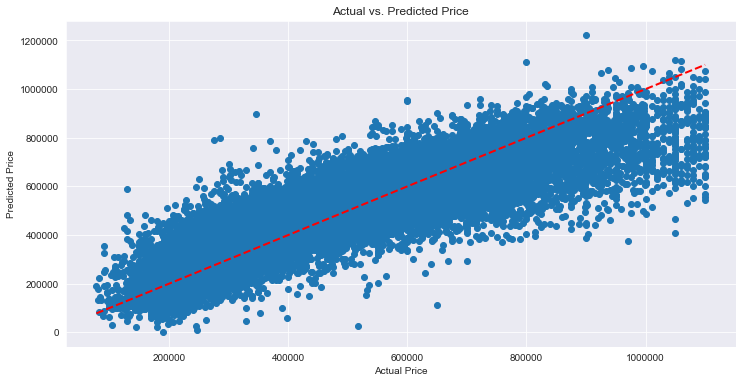

In [78]:
predicted = cross_val_predict(linreg, X, y, cv=10)

fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax.set_title('Actual vs. Predicted Price')
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
plt.show()

In [79]:
df_log.head()

,id,price,bedrooms,bathrooms,floors,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,month_sale,year_sale,sector_1,sector_2,sector_3,sector_4,Grade_A,Grade_B,Grade_C,Grade_D,home_age,waterfront_1,condition_2,condition_3,condition_5,renovation_1,log_sqft_living,log_sqft_living15,log_sqft_lot,log_sqft_lot15
0,7129300520,221900.0,3,1.00,1.0,7,1180,0.0,1955,0.0,47.5112,-122.257,10,2014,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,65,0,0,1,0,0,7.073270,7.200425,8.639411,8.639411
1,6414100192,538000.0,3,2.25,2.0,7,2170,400.0,1951,1991.0,47.7210,-122.319,12,2014,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,69,0,0,1,0,1,7.851661,7.432484,8.887653,8.941022
2,5631500400,180000.0,2,1.00,1.0,6,770,0.0,1933,0.0,47.7379,-122.233,2,2015,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,87,0,0,1,0,0,6.646391,7.908387,9.210340,8.994917
3,2487200875,604000.0,4,3.00,1.0,7,1050,910.0,1965,0.0,47.5208,-122.393,12,2014,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55,0,0,0,1,0,7.580700,7.215240,8.517193,8.517193
4,1954400510,510000.0,3,2.00,1.0,8,1680,0.0,1987,0.0,47.6168,-122.045,2,2015,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,33,0,0,1,0,0,7.426549,7.495542,8.997147,8.923058


================================================================================================

================================================================================================

<b>The strongest predictors in no particular order are the following:</b>
* waterfront_1
* sqft_living
* sqft_living15
* sqft_lot
* sector_1
* yr_sale
* grade
* Grade_A
* Grade_C
* floors
* bathrooms



================================================================================================

================================================================================================

The following are some file creation for later EDA on the Questions_and_Results notebook:

In [69]:
df2.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,year_sale,sector_1,sector_2,sector_3,sector_4,Grade_A,Grade_C,Grade_D,waterfront_1,condition_2,condition_3,condition_4,condition_5,renovation_1
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,1955,47.5112,-122.257,1340,5650,2014,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,400.0,1951,47.7210,-122.319,1690,7639,2014,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,1933,47.7379,-122.233,2720,8062,2015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,910.0,1965,47.5208,-122.393,1360,5000,2014,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,1987,47.6168,-122.045,1800,7503,2015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0


In [70]:
df_log.price.mean()

468468.61254075746

In [71]:
df2.to_csv('df2.csv')